In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/kì 2/tien xu li & xay dung bo du lieu/BTTH5_DS108/clean_data.csv')


In [41]:
#lightgbm
feat_to_keep = ['CLASSIFY_CD', 'SO_TIME', 'CUST_CD', 'PURCHASE AMOUNT', 'SUPPLIER_CD', 'WEIGHT', 'DAY_RANGE', 'DAY_OF_MONTH', 'BRAND_CD', 'Ship Mode', 'Sales order line number', 'MONTH', 'LOGICAL PLANT','label']
#catBoost
feat_to_keep_1 = ['DAY_RANGE', 'Ship Mode', 'DIRECT SHIP FLG', 'DELI_DIV', 'CLASSIFY_CD', 'SUPPLIER_CD', 'MONTH', 'DAY_OF_MONTH', 'PURCHASE AMOUNT', 'Consider count hodiday Saturday', 'LOGICAL PLANT', 'BRAND_CD', 'CUST_CD', 'SO_TIME', 'Sales order line number','label']


In [42]:
#for lightgbm
df1 = df.loc[:,feat_to_keep]
#for catBoost
df2 = df.loc[:,feat_to_keep_1]

In [6]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.9 MB/s eta 0:00:00


In [7]:
from sklearn.metrics import classification_report,f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#Evaluating models

In [34]:
def data_preparation(df,has_weight = True):
  X = df.drop(['label'],axis = 1)
  y = df['label']

  print('spliting the data')
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

  print('downsampling')
  train_df = pd.concat([X_train, y_train], axis=1)
  train_df.columns = list(X_train.columns) + ['label']

  majority_class = train_df[train_df['label'] == 0]
  minority_class = train_df[train_df['label'] == 1]

  majority_class_downsampled = resample(majority_class,
                                        replace=False,    # sample without replacement
                                        n_samples=20*len(minority_class),  # to match minority class
                                        random_state=42)

  downsampled_train_df = pd.concat([majority_class_downsampled, minority_class])

  X_train_downsampled = downsampled_train_df.drop(columns='label')
  y_train_downsampled = downsampled_train_df['label']

  if has_weight:
    X_train_downsampled['WEIGHT'] = np.log1p(X_train_downsampled['WEIGHT'])
    X_val['WEIGHT'] = np.log1p(X_val['WEIGHT'])
    X_test['WEIGHT'] = np.log1p(X_test['WEIGHT'])

  X_train_downsampled['PURCHASE AMOUNT'] = np.log1p(X_train_downsampled['PURCHASE AMOUNT'])
  X_val['PURCHASE AMOUNT'] = np.log1p(X_val['PURCHASE AMOUNT'])
  X_test['PURCHASE AMOUNT'] = np.log1p(X_test['PURCHASE AMOUNT'])

  print('scaling')
  scl = StandardScaler()
  scl.fit(X_train_downsampled)
  X_train_downsampled = scl.transform(X_train_downsampled)
  X_test = scl.transform(X_test)

  return X_train_downsampled,X_val,X_test,y_train_downsampled,y_val,y_test

##Lightgbm

In [ ]:
import lightgbm as lgb

spliting the data
downsampling
scaling
[LightGBM] [Info] Number of positive: 20974, number of negative: 419480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2354
[LightGBM] [Info] Number of data points in the train set: 440454, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047619 -> initscore=-2.995732
[LightGBM] [Info] Start training from score -2.995732
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    104869
           1       0.86      0.64      0.73      2621

    accuracy                           0.99    107490
   macro avg       0.93      0.82      0.86    107490
weighted avg       0.99      0.99      0.99    107490



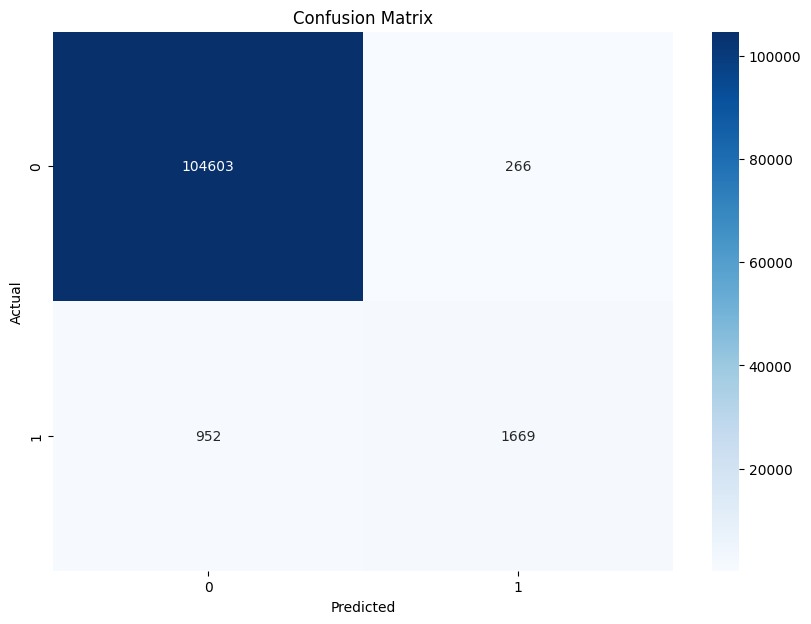

In [44]:
X_train,X_val,X_test,y_train,y_val,y_test = data_preparation(df1)

clf_lgb = lgb.LGBMClassifier(colsample_bytree=0.6, metric='auc', min_child_weight=5,
               n_estimators=256, num_leaves=256, reg_alpha=0.1, subsample=0.8)
clf_lgb.fit(X_train,y_train)

y_pred = clf_lgb.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#catBoost

In [ ]:
from catboost import CatBoostClassifier

In [35]:
#X_train,X_test,X_val,y_train,y_val,y_test = data_preparation(df2,has_weight = False)
X_train,X_val,X_test,y_train,y_val,y_test = data_preparation(df)

spliting the data
downsampling
scaling


spliting the data
downsampling
scaling
0:	learn: 0.6381028	test: 0.7002315	best: 0.7002315 (0)	total: 468ms	remaining: 7m 47s
100:	learn: 0.0809237	test: 0.4949883	best: 0.4889575 (96)	total: 17.5s	remaining: 2m 35s
200:	learn: 0.0692306	test: 0.4575658	best: 0.4398387 (173)	total: 33.5s	remaining: 2m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.346939701
bestIteration = 238

Shrink model to first 239 iterations.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    104869
           1       0.88      0.56      0.69      2621

    accuracy                           0.99    107490
   macro avg       0.94      0.78      0.84    107490
weighted avg       0.99      0.99      0.99    107490



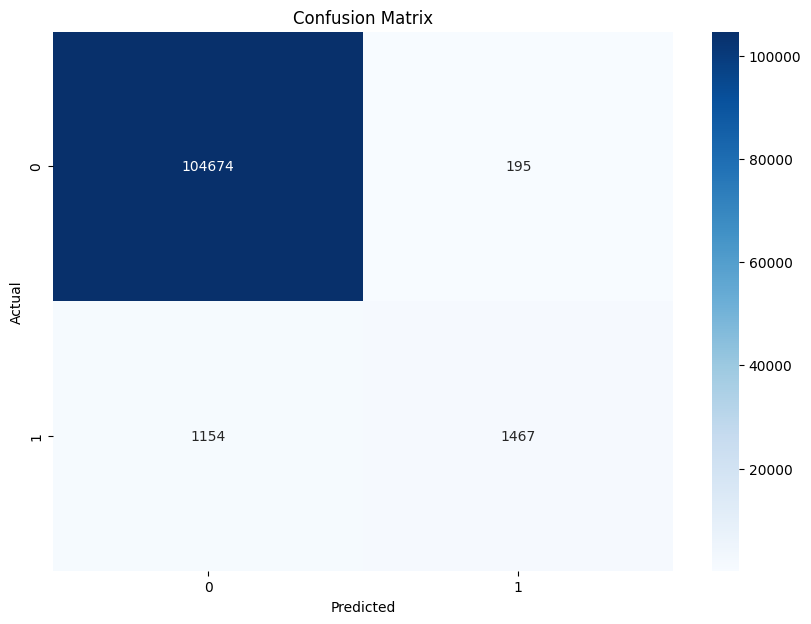

In [46]:
X_train,X_val,X_test,y_train,y_val,y_test = data_preparation(df2, has_weight = False)

cat_clf = CatBoostClassifier(learning_rate=0.03, l2_leaf_reg=4, depth=9, verbose=100)

cat_clf.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

y_pred = cat_clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()